# Experiment with Azure Digital Tween Service
[Location](https://explorer.digitaltwins.azure.net/?tid=76a2ae5a-9f00-4f6b-95ed-5d33d77c4d61&eid=digitaltwins.api.weu.digitaltwins.azure.net)

## Set up

### Create Service Instance
Create instance as described [here](https://learn.microsoft.com/en-gb/azure/digital-twins/quickstart-azure-digital-twins-explorer)

### Define models
To initial define set of models (ontology) was used Office 365 copilot and [prompt](prompts/Define%20models.txt). Some extra tuning was required.
Models are stored in `ontology` folder.
Then models were uploaded to service.

### Ontology
The service define several models as follow:

- Model name: `CentralUnit` - which is main unit of the system exists in one instance. 
    If user want to create new CentralUnit, you must refuse it with message: "Central Unit has to be created manually!"

- Model name: `ControlHub` - which is connection unit between _Central Unit_ and _Termo Sensors_. 

- Model name: `TermoSensor` - which conects to _Control Hub_ and reports temperature value.

## Gen AI
Utilise GenAI to work with toplogy
Add, update, remove digital twin to the graph.

### Overview

![ReAct](diagrams/ReAct.png)


### Init

In [9]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = f"DigTwin"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

# Access the environment variables
digital_twin_endpoint = os.getenv("AZURE_DIGITAL_TWINS_ENDPOINT")

### Define Tools

Tools that helps LLM to perform tasks on digital twins.

- `get_module_definition` - defines modules and rules of handling digital twins. It's implementation of RAG architecture where user's input _augmented_ with details of the model that needs to be maintained.
- `query_service` - requests information about _digital twin_ from Azure Digital Twins Query API.
- `create_twin`, `delete_twin` - creates or deletes _digital twin_.
- `update_relationship`, `delete_relationship` - creates or deletes _relationship_ between digital twins.


In [10]:
from azure.digitaltwins.core import DigitalTwinsClient
from azure.identity import DefaultAzureCredential
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
import json

credential = DefaultAzureCredential()

# Create an instance of the DigitalTwinsClient
client = DigitalTwinsClient(digital_twin_endpoint, credential)

class ModelDefinitionInput(BaseModel):
    model_type: str = Field(description="Model type that definition is required. For example: ControlHub or TermoSensor")

@tool("get-module-definition", args_schema=ModelDefinitionInput)
def get_module_definition(model_type:str) -> str:
    """
        Used to get the model definition in Digital Twin Definition Language (DTDL) format. Should be used to get model specification before operation on digital twin.
        
        return: DTDL of the requested model and useful instruction how to use it.  If model name is not valid, the tool returns NA it means that execution is failed.
    """
    if model_type == "ControlHub":
        with open('ontology/ControlHub.json', 'r') as file:
            definition = file.read()

        instructions = """
        IMPORTANT NOTES:
        1. The model id in $metadata section is dtmi:com:example:ControlHub;1
        2. When requested creation new digital twin it must be performed in 2 steps:
            - create new digital twin of ControlHub model
            - create relationship between new digital twin and CentralUnit twin! ID of CentalUnit twin must be queried through Azure Digital Twins Query API.
             $relationship Name should be "connects". source of the relationship is CentalUnit twin, target is ControlHub twin.
        """
        return definition + instructions
    elif model_type == "TermoSensor":
        with open('ontology/TermoSensor.json', 'r') as file:
            definition = file.read()

        instructions = """
        IMPORTANT NOTES:
        1. The model id in $metadata section is dtmi:com:example:TermoSensor;1
        2. When requested creation new digital twin it must be performed in 2 steps:
            - create new digital twin of TermoSensor model
            - create relationship between new digital twin and ControlHub twin. 
                $relationship name should be "connects"
                To make this relationship you must know id of ControlHub twin, this can be obtained by several ways:
                - user can specify id of ControlHub twin in initial request - in this case you have this information.
                - user may specidy name of ControlHub - in this case you must query its id through Azure Digital Twins Query API.
                - if user does not provide neither name nor id you should use available for you human tool and ask the name of ControlHub twin. And then use it to get id as specified above.
        """
        return definition + instructions
    else:
        return "NA"


class CreateTwinInput(BaseModel):
    twin_id: str = Field(description=
    """
    The unique identifier of the digital twin that is going to be changed or created.
    The identifier passed here must respect name convention for Azure Digital Twins Id
    (alphabetical, numbers, underscore, up to 64 symbols)
    """)
    twin_data: str = Field(description=
    """
    The format has to be Dictionary[string, object] represented as type string
    The dictionary represent digital tween to be sent to the topology.
    The format should be in Azure Digital Twins Definition Language (DTDL).
    
    IMPORTANT! The metadata section should contain id of the model, for example if
    model id is dtmi:com:example:ControlHub;1 metadata section should looks like:
    "$metadata": {
        "$model": "dtmi:com:example:ControlHub;1"
    },

    The format must be valid to be sent as twin_data in following below example.
        
    from azure.digitaltwins.core import DigitalTwinsClient
    
    client = DigitalTwinsClient(digital_twin_endpoint, credential)
    client.upsert_digital_twin(twin_id, twin_data)
    """)

@tool("create-twin-tool", args_schema=CreateTwinInput)
def create_twin(twin_id, twin_data)->str:
    """
        Adds or Updates the digital twin of Azure Digital Twins Service.
        This function should be used when you want to:
            - create new digital twin
            - update parameters for existed digital twin.

        return: SUCCESS if the operation was successful, otherwise FAIL with description of the error, you're welcome to analyse error and fix it.
    """
    
    # Send data to the topology
    try:
        twin_data_dict = json.loads(twin_data)
        client.upsert_digital_twin(twin_id, twin_data_dict)
        return "SUCCESS\n"
    except Exception as e:
        print("Error sending data to Azure Digital Twins service topology:", str(e))
        return f'FAIL: + {str(e)}\n'
    

class DeleteTwinInput(BaseModel):
    twin_id: str = Field(description=
    """
    The unique identifier of the digital twin that is going to be deleted.
    The identifier is a value of $dtId requested from Azure Digital Twins Query API
    """)

@tool("delete-twin-tool", args_schema=DeleteTwinInput)
def delete_twin(twin_id)->str:
    """
        Delete the digital twin of Azure Digital Twins Service.
        This function should be used when you want to delete digital twin.

        return: SUCCESS if the operation was successful, otherwise FAIL with description of the error, you're welcome to analyse error and fix it.
    """
    
    # Send data to the topology
    try:
        client.delete_digital_twin(twin_id)
        return "SUCCESS\n"
    except Exception as e:
        print("Error deleting digital twin in Azure Digital Twins service topology:", str(e))
        return f'FAIL: + {str(e)}\n'

class UpdateRelationshipInput(BaseModel):
    twin_id: str = Field(description=
    """
    The unique identifier of the digital twin that is going to be the source of the connection.
    The identifier is a value of $dtId requested from Azure Digital Twins Query API
    """)
    relation_id: str = Field(description=
    """
    The unique identifier of the relationship may be provided by user. If not should be
    generated by you. For example can be "connection_1"
    """)
    relation_data: str = Field(description=
    """
    The format has to be Dictionary[string, object] represented as type string
    The dictionary represent relationship to be sent to the topology.
    The format should be in Azure Digital Twins Definition Language (DTDL).
    
    The format must be valid to be sent as relation_data in following below example.
        
    from azure.digitaltwins.core import DigitalTwinsClient
    
    client = DigitalTwinsClient(digital_twin_endpoint, credential)
    client.upsert_relationship(twin_id, relation_id, relation_data)

    It must contain:
    {
        "$relationshipId": "relation_id",
        "$sourceId": "source_id",
        "$relationshipName": "connects",
        "$targetId": "target_id",
        "$metadata": {
            "$model": "model_id"
        }
    }

    where:
     - relation_id - the same unique identifier of the relationship as provided in relation_id argument
     - source_id  - the same unique identifier of the digital twin as provided in twin_id argument
     - "connects" - fixed keyword describes relationship
     - target_id - the unique identifier of the digital twin that is originally was created. This is id of twin that user ask to create or modify.
     - model_id - the unique identifier of the model that is used as source of relationship. Is obtained from model definition for source.
    """)

@tool("update-relationship-tool", args_schema=UpdateRelationshipInput)
def update_relationship(twin_id, relation_id, relation_data)->str:
    """
        Update the relationship between twins in Azure Digital Twins Service.
        This function should be used when you want to:
            - create new relationship
            - update parameters for existed relationship.
    """
    
    # Send data to the topology
    try:
        relation_data_dict = json.loads(relation_data)
        client.upsert_relationship(twin_id, relation_id, relation_data_dict)
        return "SUCCESS\n"
    except Exception as e:
        print("Error updating relationship in Azure Digital Twins service:", str(e))
        return "FAIL\n"

class DeleteRelationshipInput(BaseModel):
    twin_id: str = Field(description=
    """
    The unique identifier of the digital twin that is going to be the source of the connection.
    The identifier is a value of $dtId requested from Azure Digital Twins Query API
    """)
    relation_id: str = Field(description=
    """
    The unique identifier of the relationship to be deleted.
    The identifier is a value of $relationshipId requested from Azure Digital Twins Query API
    """)

@tool("delete-relationship-tool", args_schema=DeleteRelationshipInput)
def delete_relationship(twin_id, relation_id)->str:
    """
        Delete the relationship between twins in Azure Digital Twins Service.

        return: SUCCESS if the operation was successful, otherwise FAIL with description of the error, you're welcome to analyse error and fix it.
    """
    
    # Send data to the topology
    try:
        client.delete_relationship(twin_id, relation_id)
        return "SUCCESS\n"
    except Exception as e:
        print("Error deleting relationship in Azure Digital Twins service topology:", str(e))
        return f'FAIL: + {str(e)}\n'

class QueryTwinInput(BaseModel):
    query: str = Field(description=
    """
        Query in Azure Digital Twins Query API format that is going to be executed on Azure Digital Twin Service.
         
        For example: You need to know the details of ControlHub twin.
        From topology you may get model definition for ControlHub iand from definition understand that id is dtmi:com:example:ControlHub;1
        Thaen you can format request as:
        SELECT * FROM digitaltwins T WHERE IS_OF_MODEL(T, 'dtmi:com:example:ControlHub;1')

        The request returns all description of all twins with type ControlHub.
    """)

@tool("query-service", args_schema=QueryTwinInput)
def query_service(query:str) -> str:
    """
        Request information about twins or relationships in Azure Digital Twins Service.
        This function should be used whan you need to get information about particular twin or several items or relationships between them.

        return: response from Azure Digital Twins Query API in JSON format. If function fails it return text started with FAIL word and description of the error, you're welcome to analyse error and fix it.
    """
    if (query == None):
        return "FAIL: Query is not defined!"

    try:
        query_result = client.query_twins(query)
        json_result = json.dumps(list(query_result))
        return json_result
    except Exception as e:
        print("Error deleting digital twin in Azure Digital Twins service topology:", str(e))
        return f'FAIL: + {str(e)}\n'

tools = [
    get_module_definition,
    create_twin, delete_twin, query_service,
    update_relationship, delete_relationship
]

### Configure LLM
Configure Azure Open AI

In [11]:
from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"], # 2024-02-15-preview
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"], # gpt-4o
    temperature=0.1
)


### Define graph

In [12]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


### Prompt engineering

In [13]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

system_message = SystemMessage(
    content="""
    You are helpfull bot that is going to help with creation topology in Azure Digital Twins Service.
    You should not answer with general information.
    
    The service define several models as follow:

    - Model CentralUnit - which is main unit of the system exists in one instance. 
        You cannot create CentralUnit as it is already defined. If the creation will be requested refuse it.
    - Model ControlHub - which is connection unit between CentralUnit and TermoSensors.
    - Model TermoSensor - which conects to ControlHub and reports temperature value.

    If user want to create, update, delte or request information about any unit you must use appropriate tool(s) and provide valid parameters. 
    Digital Twin Definition Language (DTDL) must be used to communicate with Azure Digital Twins Service. Note that properties are case sensetive
    and must be passed exactly as defined in model, ignore the case of properties in user's input.

    If user requests to create a new digital twin you must also specify relationship between this twin that acts as target and the other that acts as source.
    You should never create twin without connection to source.

    If user want update or delete exsted twin then user must specify twin id. If id is not provided, use human tool to ask user for it.

    If you requested to create several twins (batch) you should think as follows:
        - identify if there is hierarchy between twins, for example is there requested ControlHub and TermoSensors.
        - if hierarchy presents you should start from "higher" twin (ControlHub) and create it accordingly to defined rules, when creation is done continue with
        "lower" twins (TermoSensors) and create them accordingly to defined rules.
        - if hierarchy is not presents you can create twins in any order.
        - once all twins are created you can create relationships between them as requested.
        - ControlHub must be connected to CentralUnit, TermoSensors must be connected to ControlHub.

    Relationship between digital twins are stored separately from twins. If user request information where connection between twins presens you must request
    relationship information from relationships collection!
    For example for question: what temperature sensor connected to hub with id Node_23 valid query will be:
    SELECT * FROM relationships WHERE $sourceId = 'Node_23'
    Note request was done for relationships not digitaltwins collection.

    """
)

### Execution

Is used ReAct approach that let LLM to think what steps should be done to achieve task and what tool is better fit this needs.

#### Control Hub

- Add Control Hub

In [15]:
human_message = HumanMessage(
    content="Please create Control Hub with following parameters: Name: Hub_3, Location: Rivno, Status: on."
)

- Delete Control Hub

In [18]:
human_message = HumanMessage(
    content="Please delete Control Hub: Hub_3"
)

In [8]:
human_message = HumanMessage(
    content="Where is located Control Hub Odesa_Hub?"
)

#### Add Temperature Sensor

In [12]:
human_message = HumanMessage(
    content="Please create new TermoSensor with following parameters: Name: Sensor_1, Location: Rivno, Temperature: 22, Status: on. This sensor must be connected to ControlHub id: Hub_3"
)

#### Batch Task

- add twins

In [18]:
human_message = HumanMessage(
    content="""I want to add new location that contains 5 sensors. Status for all of them on. 
    They should be conected to ControlHub that is located in Odesa give the hub id meaningful value that reflects its location.
    Location of sensor is the same as hub. Set temperature to each sensor as 39.
    Do not forget to connect ControlHub to CentralUnit"""
)


- remove twins

In [20]:
human_message = HumanMessage(
    content="Please clean toplogy, remove all control hubs and termo sensors."
)

#### Start ReAct

Reffer to [LangChain to LangGrap migration documentation](https://python.langchain.com/v0.2/docs/how_to/migrate_agent/).

In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain_community.adapters.openai import convert_message_to_dict


graph = create_react_agent(model, tools=tools, messages_modifier=system_message)


input = {
    "messages":[
        human_message,
    ]
}

print_stream(
    graph.stream(input, stream_mode="values")
)


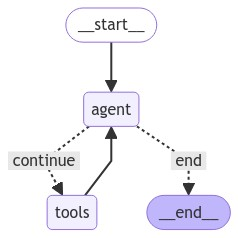

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))